<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/6_1_chatbot_external_memory_with_our_db_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with message summarization & external DB memory

## Review

Hum ne graph state schema aur reducer ko customize karne ka tareeqa discuss kiya hai.

Hum ne kuch tricks bhi dikhayi hain jo graph state mein messages ko trim ya filter karne ke liye use hoti hain.

In concepts ka istemal hum ne ek Chatbot ke sath kiya hai jo memory rakhta hai aur conversation ka ek running summary produce karta hai.








## Goals

Lekin, agar hum chahte hain ke hamara Chatbot aisi memory rakhe jo hamesha ke liye persist kare?

Ab hum kuch advanced checkpointers introduce karenge jo external databases ko support karte hain.








Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

## Use Cases for Database File Management:
1. Fetching a Database File from a GitHub URL
2. Uploading a Database File from Your Local System
3. Accessing a Database File from Google Drive

GitHub, local system, aur Google Drive se database files ko fetch, upload, aur access karne ke liye

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_google_genai

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

In [ ]:
import os
os.environ["Langchain_api_key"] = userdata.get('GOOGLE_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database.

If we supply `":memory:"` it creates an in-memory Sqlite database.

In [ ]:
import sqlite3
# In memory - temporary database is created, not on-disk database
conn = sqlite3.connect(":memory:", check_same_thread = False) #check_same_thread = False | allowing multiple threads to share and use the same SQLite database connection. By default it is True

## Default Behavior:

Jab aap code pehli dafa run karte hain, yeh automatically ek nayi example.db file fetch karega. Lekin agar hum ek database ka path provide karein, to yeh hamare liye ek naya database create karega!

In [ ]:
import sqlite3
# pull file if it doesn't exist and connect to local db

!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-01-02 07:57:01--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-01-02 07:57:02--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.01s   

2025-01-02 07:57:02 (7.61 MB/s) - ‘s

## Mount with Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


connection is establish

In [ ]:
import sqlite3
file_path = '/content/drive/My Drive/state_db/example.db'
conn = sqlite3.connect(file_path)

### When you want to pass your DB file:
You need example.db as well as example.db-wal file to retrieve your previous data.

Sqlite uses these 3 files:


1.   example.db
2.   example.db-wal
3.   example.db-shm

### How SQLite Uses These Files
1. example.db: Ye main database file hai jahan committed data store hota hai.

2. example.db-wal: Agar SQLite WAL (Write-Ahead Logging) mode mein ho, to yeh file temporarily un changes ko hold karti hai jo abhi checkpoint (example.db mein write) nahi hue. SQLite jab database se connect hota hai, to yeh file automatically read karta hai.

3. example.db-shm: Yeh file shared memory ke liye use hoti hai jab multiple connections ek hi database ko access karte hain. Yeh ek temporary file hai aur persistence ko affect nahi karti.


### Why you need to save example.db-wal file along with example.db file?

Uncommitted Changes example.db-wal Mein Store Hoti Hain:
WAL mode mein, SQLite sab changes ko direct example.db file mein modify karne ke bajaye example.db-wal file mein likhta hai.

Yeh changes sirf tab merge (checkpointed) hote hain jab checkpoint operation hota hai.
Agar aap sirf example.db file copy ya use karein bina example.db-wal ke, to WAL file mein maujood uncommitted changes lost ho jayengi.
Data Consistency Ensure Karta Hai:
Agar aap database (example.db) ko kisi aur system par transfer karein bina example.db-wal ke, aur pending writes WAL file mein ho, to database incomplete ya inconsistent lag sakta hai.

Concurrent Access:
WAL file multiple processes ko allow karta hai ke wo database se simultaneously read aur write karein bina ek dusre ko block kiye. Agar yeh feature use ho raha ho, to example.db-wal file proper functionality ke liye zaroori hai.








In [ ]:
#Follow step if you already have previous database file
#uplaod example.db file from your system
from google.colab import files
uploaded = files.upload()


Saving example.db to example.db


# note:
this file uploaded by my local system....

In [ ]:
#Follow step if you already have previous database file
#upload example.db-wal file from your system
uploaded = files.upload()


In [ ]:
#Follow step if you already have previous database file
#move both files to state_db folder and establish a connection:

import sqlite3
import shutil
import os

# Ensure the state_db directory exists
os.makedirs("state_db", exist_ok=True)

# Move the uploaded files to the state_db directory
shutil.move("example.db", "state_db/example.db")
if os.path.exists("example.db-wal"):  # Check if WAL file exists
    shutil.move("example.db-wal", "state_db/example.db-wal")
    print("WAL file moved successfully.")
else:
    print("No WAL file found. Proceeding with example.db only.")

# Define the path to the main database file
db_path = "state_db/example.db"

# Connect to the SQLite database
try:
    conn = sqlite3.connect(db_path, check_same_thread=False)
    print(f"Connected to database: {db_path}")
except sqlite3.OperationalError as e:
    print(f"Error connecting to the database: {e}")


WAL file moved successfully.
Connected to database: state_db/example.db


In [ ]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

Let's re-define our chatbot.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash", api_key =  GEMINI_API_KEY)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")
    print(f"Using summary: {summary}")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    print(f"Messages before summarizing: {len(state['messages'])}")
    # First, we get any existing summary
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Summarization logic
    print(f"New summary: {response.content}")

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    print(f"Messages after truncation: {len(delete_messages)}")
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]
    print(f"Message count: {len(messages)}")
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

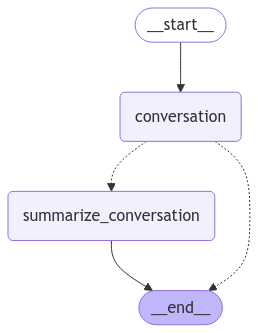

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="assalamualykum. im hafiz naveed uddin.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


Using summary: 


Message count: 8
Messages before summarizing: 8
Existing summary: 
New summary: The conversation began with Hafiz Naveed Uddin introducing himself.  The AI confirmed his name and then engaged in brief discussions about his fondness for the Kaaba in Makkah.  The conversation ended with another Islamic greeting.  The core of the interaction was a simple exchange of pleasantries and a demonstration of the AI's ability to remember and use information provided by the user.

Messages after truncation: 6
================================== Ai Message ==================================

Wa alaikum assalam Hafiz Naveed Uddin.  Peace be upon you.


Let's confirm that our state is saved locally.

In [ ]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


Using summary: The conversation began with Hafiz Naveed Uddin introducing himself.  The AI confirmed his name and then engaged in brief discussions about his fondness for the Kaaba in Makkah.  The conversation ended with another Islamic greeting.  The core of the interaction was a simple exchange of pleasantries and a demonstration of the AI's ability to remember and use information provided by the user.

Message count: 4
================================== Ai Message ==================================

Your name is Hafiz Naveed Uddin.


In [ ]:
input_message = HumanMessage(content="I like Makkah Khana Kaba!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: The conversation began with Hafiz Naveed Uddin introducing himself.  The AI confirmed his name and then engaged in brief discussions about his fondness for the Kaaba in Makkah.  The conversation ended with another Islamic greeting.  The core of the interaction was a simple exchange of pleasantries and a demonstration of the AI's ability to remember and use information provided by the user.

Message count: 6
================================== Ai Message ==================================

The Kaaba is a truly sacred and awe-inspiring place.  It's understandable why you would feel such a strong connection to it.


In [ ]:
config = {"configurable": {"thread_id": "2"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='assalamualykum. im hafiz naveed uddin.', additional_kwargs={}, response_metadata={}, id='e7534eaa-ec99-4d6f-b7c9-b86d40b68e4f'), AIMessage(content='Wa alaikum assalam Hafiz Naveed Uddin.  Peace be upon you.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9f44c4ca-5353-4260-a902-e4f768af3ce6-0', usage_metadata={'input_tokens': 132, 'output_tokens': 19, 'total_tokens': 151, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='be892b2d-009c-4af1-ad46-e759d7336ad6'), AIMessage(content='Your name is Hafiz Naveed Uddin.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c79f94ff-d988-4da8-bd3a-8105d92ffb75-0', usage_metadata={'input_to

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages = graph.get_state(config).values.get("messages")
len(messages)

6

In [ ]:
graph_state = graph.get_state(config).values.get("summary","")
graph_state

"Here's a summary of the conversation:\n\nLance introduced himself twice during the conversation. He expressed his fondness for the San Francisco 49ers football team. The AI assistant acknowledged Lance's name each time and showed willingness to discuss the 49ers, offering to talk about various aspects of the team such as their history, current roster, or memorable games. The conversation was brief and somewhat repetitive, with Lance reintroducing himself at the end without directly responding to the AI's questions or prompts about the 49ers."

In [ ]:
!ls state_db


example.db  example.db-shm  example.db-wal


Download required db files

In [ ]:
from google.colab import files
files.download('state_db/example.db')
files.download('state_db/example.db-wal')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Persisting state

SQLite jaise database ka istemal karne ka matlab hai ke state persist hoti hai!

For example, agar hum notebook kernel ko dobara start karein, to bhi hum disk par maujood SQLite database se data load kar sakte hain.

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Now that we better understand external memory, recall that the LangGraph API packages your code and provides you with with built-in persistence.

And the API is the back-end for Studio!

Load the `chatbot` in the UI, which uses `module2-/studio/chatbot.py` set in `module2-/studio/langgraph.json`.